In [2]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install biopython

In [57]:
from Bio import SeqIO

#Ex.1: read file, one hot encode, decode; use an example

#Step 1: read file - sequence + functionality
#Create dictionary: keys = sequence_n; values = prot sequence, functionality
file = "./MSA_nat_with_annotation.faa"

data_dict = {}
for seq_record in SeqIO.parse(file, "fasta"):
    data_dict[seq_record.id] = seq_record.seq, seq_record.description.replace(seq_record.id+' ','',1)
    #if seq_record.description.replace(seq_record.id+' ','',1) == "functional_true":
        #label = 1
    #else:
        #label = 0
    #data_dict[seq_record.id] = seq_record.seq, label
    #print(seq_record.id)
    #print(seq_record.description.replace(seq_record.id+' ','',1))
    #print(repr(seq_record.seq))
    #print(len(seq_record))

print(data_dict.get("sequence_1")[0])
print(data_dict.get("sequence_1")[1])
print(data_dict.get("sequence_2")[0])
print(data_dict.get("sequence_2")[1])

-TSENPLLALREKISALDEKLLALLAERRELAVEVGKAKLLSHRPVRDIDRERDLLERLITLGK-AHHLDAHYITRLFQLIIEDSVLTQQALLQQH
functional_true
---DERIQALRKEVDRVNREILRLLSERGRLVQEIGRLQTELGLPHYDPKREEEMLAYLTAEN--PGPFPDETIRKLFKEIFKASLDLEERQDQ--
functional_false


In [58]:
#One hot encoding
import numpy as np

# define alphabet of possible input values
alphabet ='ACDEFGHIKLMNPQRSTVWY-'

def one_hot_encoder(MSA_str, alphabet):
    # define a mapping of chars to integers
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    # integer encode input data
    integer_encoded = [char_to_int[char] for char in MSA_str]
    # one hot encode
    onehot_encoded = list()
    for value in integer_encoded:
        if value == char_to_int.get("-"):
            letter = [0 for value in range(len(alphabet)-1)]
        else:
            letter = [0 for value in range(len(alphabet)-1)]
            letter[value] = 1
        onehot_encoded.append(letter)
    return onehot_encoded

#cuz you don't set a lock without getting a key
def one_hot_decoder(encoded_str, alphabet):
    # define a mapping of integers to chars
    int_to_char = dict((i, c) for i, c in enumerate(alphabet))
    decoded = ''
    for i in range(np.shape(encoded_str)[0]):
        if np.count_nonzero(encoded_str[i]) == 0:
            inverted = '-'
        else:
            inverted = int_to_char[np.argmax(encoded_str[i])]
        decoded += inverted
    return decoded

#Check that - is properly encoded 
tmp_sequence = "-"
encoded = one_hot_encoder(tmp_sequence, alphabet)
print(encoded)
decoded = one_hot_decoder(encoded, alphabet)
print(decoded)

#Example + get arrays lengths
tmp_sequence = data_dict.get("sequence_1")[0]
encoded_ref = one_hot_encoder(tmp_sequence, alphabet)
print(np.shape(encoded))
decoded = one_hot_decoder(encoded_ref, alphabet)
print(tmp_sequence)
print(decoded)

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
-
(1, 20)
-TSENPLLALREKISALDEKLLALLAERRELAVEVGKAKLLSHRPVRDIDRERDLLERLITLGK-AHHLDAHYITRLFQLIIEDSVLTQQALLQQH
-TSENPLLALREKISALDEKLLALLAERRELAVEVGKAKLLSHRPVRDIDRERDLLERLITLGK-AHHLDAHYITRLFQLIIEDSVLTQQALLQQH


In [59]:
#Create a single array of encoded data to apply PCA on: single one hot vector
encoded_data = np.empty([len(data_dict), np.shape(encoded_ref)[0]*np.shape(encoded_ref)[1]])
for i in range(len(data_dict)):
    sequence = data_dict.get("sequence_"+str(i+1))[0]
    encoded = one_hot_encoder(sequence, alphabet)
    concatenated = encoded[0]
    for j in range(len(encoded)-1):
        concatenated = np.concatenate((concatenated, encoded[j+1]), axis = None)
    encoded_data[i] = concatenated
    
print(np.shape(encoded_data))

#create array of labels: 1 if functional_true, O if functional_false
labels = np.empty(len(data_dict))
for i in range(len(data_dict)):
    if data_dict.get("sequence_"+str(i+1))[1] == "functional_true":
        labels[i]=1
    else:
        labels[i]=0
print(np.shape(labels))

(1130, 1920)
(1130,)


In [60]:
#Apply PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardizing the features
encoded_data = StandardScaler().fit_transform(encoded_data)

pca = PCA(n_components=4)
principalComponents = pca.fit_transform(encoded_data)

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
print(np.shape(principalComponents))

Explained variation per principal component: [0.01851641 0.01602756 0.01504452 0.01288503]
(1130, 4)


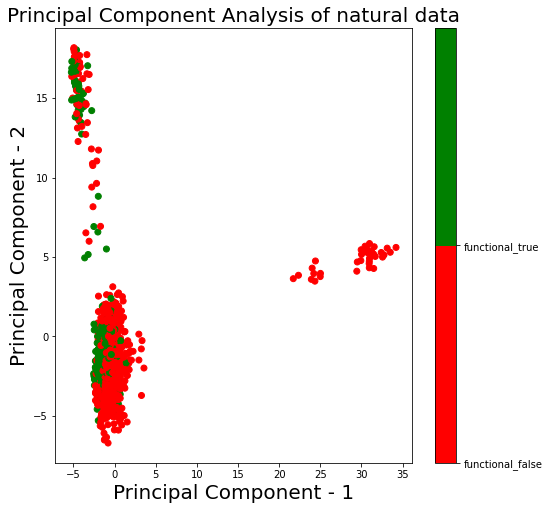

In [65]:
import matplotlib
import matplotlib.pyplot as plt

#red => 0 => functional_false; green => 1 => functional_true
colors = ['red','green']

fig = plt.figure(figsize=(8,8))
plt.scatter(principalComponents[:,0], principalComponents[:,1], c=labels, 
            cmap=matplotlib.colors.ListedColormap(colors))
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of natural data",fontsize=20)

cb = plt.colorbar()
loc = np.arange(0,max(labels),max(labels)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(["functional_false", "functional_true"])

(1003, 1920)
Explained variation per principal component: [0.02776581 0.02524508 0.02456655 0.02251503]


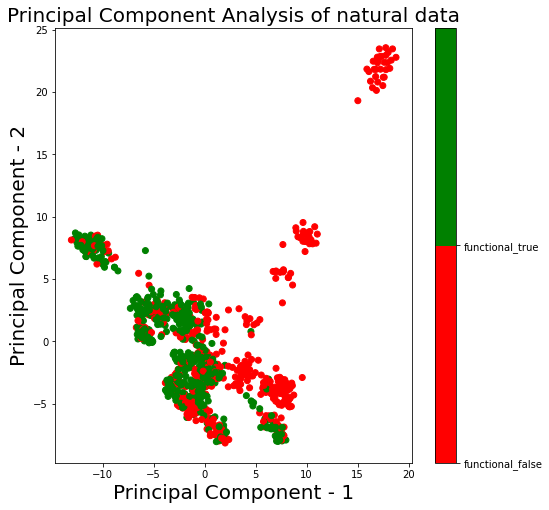

In [67]:
file = "./MSA_art.faa"
data_dict = {}
for seq_record in SeqIO.parse(file, "fasta"):
    data_dict[seq_record.id] = seq_record.seq, seq_record.description.replace(seq_record.id+' ','',1)

#Same with artificial data
encoded_data = np.empty([len(data_dict), np.shape(encoded_ref)[0]*np.shape(encoded_ref)[1]])
for i in range(len(data_dict)):
    sequence = data_dict.get("sequence_"+str(i+1))[0]
    encoded = one_hot_encoder(sequence, alphabet)
    concatenated = encoded[0]
    for j in range(len(encoded)-1):
        concatenated = np.concatenate((concatenated, encoded[j+1]), axis = None)
    encoded_data[i] = concatenated
    
print(np.shape(encoded_data))

#create array of labels: 1 if functional_true, O if functional_false
labels = np.empty(len(data_dict))
for i in range(len(data_dict)):
    if data_dict.get("sequence_"+str(i+1))[1] == "functional_true":
        labels[i]=1
    else:
        labels[i]=0

# Standardizing the features
encoded_data = StandardScaler().fit_transform(encoded_data)

pca = PCA(n_components=4)
principalComponents = pca.fit_transform(encoded_data)

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

#red => 0 => functional_false; green => 1 => functional_true
colors = ['red','green']

fig = plt.figure(figsize=(8,8))
plt.scatter(principalComponents[:,0], principalComponents[:,1], c=labels, 
            cmap=matplotlib.colors.ListedColormap(colors))
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of natural data",fontsize=20)

cb = plt.colorbar()
loc = np.arange(0,max(labels),max(labels)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(["functional_false", "functional_true"])